In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import talib
sns.set()

## Fetching the Data from Yahoo Finance

In [155]:
## Fetch the Data from Yahoo Finance
vix_data = yf.download('^INDIAVIX', start='2014-01-01', end='2025-08-04')['Close']
nifty_data = yf.download('^NSEI', start='2014-01-01', end='2025-08-04')

C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\2487781888.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download('^INDIAVIX', start='2014-01-01', end='2025-08-04')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\2487781888.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download('^NSEI', start='2014-01-01', end='2025-08-04')
[*********************100%***********************]  1 of 1 completed


## Cleaning the Data and generating features

In [156]:
## Clean the data
vix_series = vix_data.dropna()
nifty_close = nifty_data['Close']
nifty_volume = nifty_data['Volume']
features = pd.DataFrame(index=vix_series.index)
features['vix_lag1'] = vix_series.shift(1)   #Feature : INDIAVIX value today
features['vix_roll_mean'] = vix_series.rolling(5).mean().shift(1) # 5 day rolling mean of INDIAVIX
features['vix_roll_std'] = vix_series.rolling(5).std().shift(1)  # 5 day Volatility of INDIAVIX
features['nifty_ret'] = nifty_close.pct_change().shift(1)  #NIFTY 1 day return
features['nifty_vol'] = nifty_close.pct_change().rolling(5).std().shift(1) #NIFTY 5 day Volatility
features['Date1'] = features.index  # Creating the Date column
nifty_close['Date1'] = nifty_close.index
li = nifty_close['^NSEI'].to_numpy()
rsi = talib.RSI(li, timeperiod=14)
nifty_close['rsi'] = rsi              #Calculate NIFTY RSI
macd,_,_ = talib.MACD(li,fastperiod=12, slowperiod=26, signalperiod=9)  #Calculate NIFTY MACD
nifty_close['macd'] = macd

#Just some data cleaning
nifty_close = nifty_close[['Date1','rsi','macd']]
nifty_close['rsi'] = nifty_close['rsi'].shift(1)
#nifty_close['macd'] = nifty_close['macd'].shift(1)
features = features.merge(nifty_close,on=['Date1'],how='left')

# More Data Cleaning
nifty_volume = nifty_volume.shift(1)
nifty_volume['Date1'] = nifty_volume.index
nifty_volume['volume'] = nifty_volume['^NSEI']
nifty_volume = nifty_volume[['Date1','volume']]
features = features.merge(nifty_volume,on=['Date1'],how='left')
features = features.drop(columns=['Date1'])
vix_series = vix_series.reset_index()
vix_series = vix_series[['^INDIAVIX','Date']]
#vix_series

C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\1594671293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty_close['Date1'] = nifty_close.index
C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\1594671293.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty_close['rsi'] = rsi              #Calculate NIFTY RSI
C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\1594671293.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

## Training the Random Forest Model

In [157]:
feature = ['vix_lag1','vix_roll_mean','vix_roll_std','nifty_ret','nifty_vol','rsi','macd','volume']

In [158]:
vix_series['Change'] = (vix_series['^INDIAVIX'] - vix_series['^INDIAVIX'].shift(1)) > 0  #Calculating if INDIAVIX increased or decreased in value
vix_series = vix_series[['Change','Date']]
features = features.dropna()
target = vix_series.loc[features.index]  # Predict VIX level
target1 = target

# Output Variable
target = target[['Change']]
target1['Index'] = target1.index

# Training the Random Forest Model
train_size = int(len(features) * 0.7)
features = features[feature]
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict_proba(X_test_scaled)

C:\Users\HP 1030\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Analyzing the model output and performing the backtest

In [159]:
y_test = y_test[['Change']]
y_test['Index'] = y_test.index
y_test = y_test.merge(target1,on='Index',how='left')
y_test = y_test[['Change_x','Date']]
y_test.columns = ['Change','Date']
#y_test = y_test[['Change']]
y_test = y_test.reset_index(drop=True)
for i in range(0,len(y_test)):
#for i in range(0,1):
    if y_pred[i][0] >= 0.5:
        y_test.loc[i,'Predicted'] = False
 #       print(1)
    elif y_pred[i][1] >= 0.5:
        y_test.loc[i,'Predicted'] = True
 #       print(2)
    else:
        y_test.loc[i,'Predicted'] = 'Not Clear'
 #       print(3)
vix_data = yf.download('^INDIAVIX', start='2022-03-03', end='2025-08-02')
vix_data['Date'] = vix_data.index
vix_data = vix_data[['Close','High','Low','Open','Date']]
vix_data.columns = ['Close','High','Low','Open','Date']
vix_data = vix_data.reset_index(drop=True)
y_test1 = y_test[y_test['Predicted'] != 'Not Clear'].reset_index(drop=True)
y_test = y_test.merge(vix_data,on=['Date'],how='left')

y_test1 = y_test1.reset_index(drop=True)
for i in range(0,len(y_test1)):
    if y_test1.loc[i,'Change']==y_test1.loc[i,'Predicted']:
        y_test1.loc[i,'Accurate'] = 1
    else:
        y_test1.loc[i,'Accurate'] = 0
accuracy = 100*y_test1['Accurate'].sum()/len(y_test1)
accuracy

C:\Users\HP 1030\AppData\Local\Temp\ipykernel_13884\2688722325.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download('^INDIAVIX', start='2022-03-03', end='2025-08-02')
[*********************100%***********************]  1 of 1 completed


np.float64(56.904761904761905)

## Simulating the portfolio and analyzing the distribution returns

In [160]:
initial_value = 100000
slippage = 0.025
transaction_cost = 100
for i in range(0,len(y_test)):
    if y_test.loc[i,'Predicted']==False:
        initial_value = initial_value*((y_test.loc[i,'Open']-slippage)/(y_test.loc[i,'Close']+slippage))-transaction_cost
        y_test.loc[i,'Portfolio'] = initial_value
        if i==0:
            y_test.loc[i,'Returns'] = (y_test.loc[i,'Portfolio']/100000)-1
        else:
            y_test.loc[i,'Returns'] = (y_test.loc[i,'Portfolio']/y_test.loc[i-1,'Portfolio'])-1
    elif y_test.loc[i,'Predicted']==True:
        initial_value = initial_value*((y_test.loc[i,'Close']-slippage)/(y_test.loc[i,'Open']+slippage))-transaction_cost
        y_test.loc[i,'Portfolio'] = initial_value
        if i==0:
            y_test.loc[i,'Returns'] = (y_test.loc[i,'Portfolio']/100000)-1
        else:
            y_test.loc[i,'Returns'] = (y_test.loc[i,'Portfolio']/y_test.loc[i-1,'Portfolio'])-1
    else:
        y_test.loc[i,'Portfolio'] = initial_value
        y_test.loc[i,'Returns'] = 0.0
y_test.tail()  

,Change,Date,Predicted,Close,High,Low,Open,Portfolio,Returns
835,True,2025-07-28,True,12.06,12.23,10.33,11.28,481019.187978,0.064352
836,False,2025-07-29,False,11.53,12.30,11.40,12.06,500900.974724,0.041333
837,False,2025-07-30,True,11.21,11.78,10.61,11.53,484761.752564,-0.032220
838,True,2025-07-31,True,11.54,12.12,11.21,11.21,496743.039014,0.024716
839,True,2025-08-01,False,11.98,12.11,11.40,11.54,476367.829522,-0.041018


In [161]:
y_test['Returns'].describe()

count    840.000000
mean       0.003170
std        0.050706
min       -0.398221
25%       -0.022908
50%        0.002743
75%        0.028542
max        0.412646
Name: Returns, dtype: float64

In [96]:
sharpe = (252*(0.00219)-0.06)/(np.sqrt(252)*0.050805)
sharpe

np.float64(0.6098913000156766)

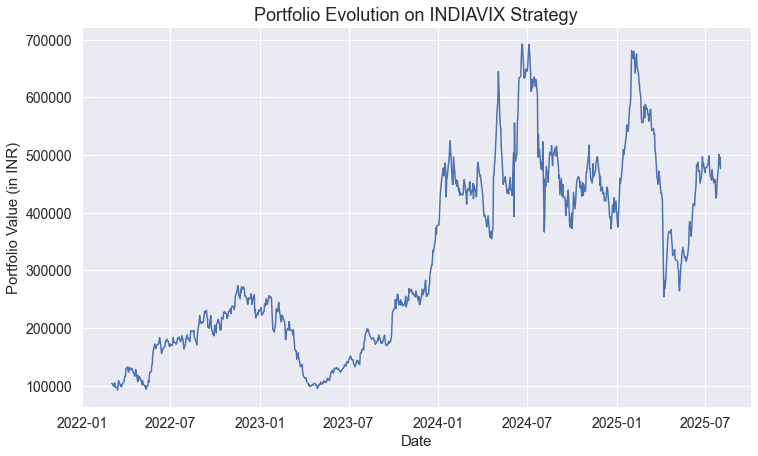

In [162]:
plt.figure(figsize=(12,7))
plt.xlabel('Date',fontsize=15)
plt.ylabel('Portfolio Value (in INR)',fontsize=15)
plt.title('Portfolio Evolution on INDIAVIX Strategy',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(y_test['Date'],y_test['Portfolio'])